# Actividad

En esta actividad vas a trabajar con el clasificador que está en el _notebook_ junto a esta actividad. Aquí debes usar esta clase para crear un clasificador de _spam_. En concreto se te pide lo siguiente:

1. **(2.5 pts)** Crea un clasificador Naive Bayes que se entrene con los asuntos (_Subject_) del _dataset_ de correos que te presentamos. Separa el _dataset_ de tres formas: (1) 0.5 de entrenamiento y prueba; (2) 0.7 de entrenamiento y 0.3 de prueba; (3) 0.3 de entrenamiento y 0.7 de prueba. ¿Cómo se comporta el clasificador en cada uno de estos escenarios? ¿Qué puedes concluir respecto al _ratio_ entrenamiento / prueba? Para cada uno de los casos presenta la matriz de confusión.

2. **(2.5 pts)** En esta parte tienes que experimentar con la precisión y el _recall_, para esto:
  - **(1 pto)** Identifica cuál es el threshold en este caso. ¿Cómo puedes hacer un modelo más preciso? ¿Cómo puedes hacer un modelo con más _recall_? Discute cómo cambiarías el código para lograr ambas cosas.
  - **(1.5 pts)** Prueba la precisión y el _recall_ para distintos valores del threshold y discute los resultados. Grafica la curva de precisión y _recall_ vs el threshold.
  
3. **(1 pto)** Supón que ahora en vez de clasificar _spam_ y _no spam_ quieres hacer un modelo que lo clasifique para distintas etiquetas. Por ejemplo, imagina que tienes una etiqueta para cada uno de tus cursos, y quieres clasificar los correos a algunas de esas etiquetas. ¿Cómo puedes extender el modelo para que sea multiclase? No es necesario mostrar código, solamente que lo expliques con tus propias palabras.

4. **(0.5 pts) \[BONUS\]** Grafica la curva ROC del modelo para tu set de prueba. Discute los resultados.

## Detalles académicos

Este control pueden realizarlo en grupos de hasta dos personas. La entrega de este control debe ser un archivo comprimido donde se encuentre un **Jupyter Notebook**, junto a cualquier archivo .csv que estés llamando desde tu código. **La fecha de entrega es hasta jueves 17 de septiembre, hasta las 20:00 pm, cualquier entrega después de este plazo será calificada con la nota mínima**. La nota se calcula como el número de puntos + un punto base. El archivo comprimido se entrega en un cuestionario de Webcursos.

In [129]:
import re
#Tokenize text
def tokenize(text):
    text = text.lower()                         # Pasar a minúsculas
    all_words = re.findall("[a-z0-9']+", text)  # Extraer las palabras con expresiones regulares
    return set(all_words)                       # Con un Set no tenemos duplicados

#tokenize("Hola! este es un mensaje de ejemplo :)")

In [130]:
class Mail():
    """Clase Mail"""
    def __init__(self, content, is_spam):
        self.content = content
        self.is_spam = is_spam

In [131]:
from collections import defaultdict # Diccionario con valores default
import math

class NaiveBayesClassifier:
    """Clasificador Naive Bayes"""
    def __init__(self, k=0.5):
        self.k = k  # smoothing factor

        self.tokens = set()
        self.token_spam_counts = defaultdict(int)
        self.token_ham_counts = defaultdict(int)
        self.spam_messages = 0
        self.ham_messages = 0

    # Función para entrenar
    def fit(self, messages):
        for message in messages:
            # Increment message counts
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.ham_messages += 1

            # Increment word counts
            for token in tokenize(message.content):
                self.tokens.add(token)
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_ham_counts[token] += 1

    # Función que calcula las probabilidades asociadas a cada palabra
    # Si la palabra no está usaremos (1 - la probabilidad)
    def probabilities(self, token):
        # Retorna P(token | spam) y P(token | not spam)
        spam = self.token_spam_counts[token]
        ham = self.token_ham_counts[token]

        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)

        return p_token_spam, p_token_ham

    # Función para predecir un texto
    def predict(self, text):
        text_tokens = tokenize(text)
        log_prob_if_spam = 0.0
        log_prob_if_ham = 0.0

        # Vemos todo nuestro vocabulario
        for token in self.tokens:
            prob_if_spam, prob_if_ham = self.probabilities(token)

            # Si el token aparece en el mensaje sumamos el log de la probabilidad asociada
            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_ham += math.log(prob_if_ham)

            # En otro caso, sumamos el log de la probabilidad de no haberlo visto: log(1 - probabilidad de ver el mensaje)
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_ham += math.log(1.0 - prob_if_ham)

        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_ham = math.exp(log_prob_if_ham)
        return prob_if_spam / (prob_if_spam + prob_if_ham)
    

In [132]:
import random

# Función para hacer split de un dataset
def split_data(data, perc):
    data = data[:]                    # Copiamos el dataset
    random.shuffle(data)              # porque shuffle modifica la lista, aquí la ordenamos de forma aleatoria
    cut = int(len(data) * perc)       # Vemos hasta que posición tomamos
    return data[:cut], data[cut:]     # Retornamos las dos partes

PATH_MAILS = 'mails/*/*'

data = []

import glob, re

# Recorremos todos los archivos
for filename in glob.glob(PATH_MAILS):
    # Checkeamos si es spam o no
    is_spam = 'ham' not in filename
    
    # Ignoramos los posibles errores al abrir un archivo
    with open(filename, errors='ignore') as mail_file:
        for line in mail_file:
            if line.startswith("Subject:"):
                # Hacemos strip desde la izquierda
                subject = line.lstrip("Subject: ")
                data.append(Mail(subject, is_spam))
                # Después de añadir el subject terminamos
                break

### 1.1) 50% entrenamiento y prueba

In [133]:
import numpy as np

In [134]:
train_mails, test_mails = split_data(data, 0.5)

In [135]:
model = NaiveBayesClassifier(k=0.5)
model.fit(train_mails)

In [136]:
prob_predict = [] #guarda probabilidades
target = []  #guarda clase
for mail in test_mails:
    prob_predict.append(model.predict(mail.content))
    target.append(mail.is_spam)

In [137]:
y_true = np.array(target)
y_predict = np.array(prob_predict)

In [138]:
#Un correo será spam si la probabilidad es mayor o igual a 0.5.
y_predict = y_predict >= 0.5

In [139]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [140]:
confusion_matrix(y_true, y_predict)

array([[1355,   24],
       [ 134,  137]])

In [141]:
accuracy_score(y_true, y_predict)

0.9042424242424243

In [142]:
recall_score(y_true, y_predict)

0.5055350553505535

### 1.1) 70% entrenamiento y 30% prueba

In [143]:
train_mails, test_mails = split_data(data, 0.7)
model = NaiveBayesClassifier(k=0.5)
model.fit(train_mails)
prob_predict = [] #guarda probabilidades
target = []  #guarda clase
for mail in test_mails:
    prob_predict.append(model.predict(mail.content))
    target.append(mail.is_spam)
y_true = np.array(target)
y_predict = np.array(prob_predict)
y_predict = y_predict >= 0.5
confusion_matrix(y_true, y_predict)

array([[804,  30],
       [ 57,  99]])

In [144]:
recall_score(y_true, y_predict)

0.6346153846153846

In [145]:
accuracy_score(y_true, y_predict)

0.9121212121212121

### 1.1) 30% entrenamiento y 70% prueba

In [146]:
train_mails, test_mails = split_data(data, 0.3)
model = NaiveBayesClassifier(k=0.5)
model.fit(train_mails)
prob_predict = [] #guarda probabilidades
target = []  #guarda clase
for mail in test_mails:
    prob_predict.append(model.predict(mail.content))
    target.append(mail.is_spam)
y_true = np.array(target)
y_predict = np.array(prob_predict)
y_predict = y_predict >= 0.5
confusion_matrix(y_true, y_predict)

array([[1937,   24],
       [ 197,  152]])

In [147]:
accuracy_score(y_true, y_predict)

0.9043290043290043

In [148]:
recall_score(y_true, y_predict)

0.4355300859598854

In [149]:
from sklearn.model_selection import cross_val_score
def NBC_scores(train, umbral, k=0.5):
    train_mails, test_mails = split_data(data, train)
    model = NaiveBayesClassifier(k)
    model.fit(train_mails)
    prob_predict = [] #guarda probabilidades
    target = []  #guarda clase
    for mail in test_mails:
        prob_predict.append(model.predict(mail.content))
        target.append(mail.is_spam)
    y_true = np.array(target)
    y_predict = np.array(prob_predict)
    y_predict_umbral = y_predict >= umbral
    return y_true, y_predict_umbral, y_predict

#### ¿Cómo se comporta el clasificador en cada uno de estos escenarios? ¿Qué puedes concluir respecto al ratio entrenamiento / prueba? 
En general en los tres casos el desempeño fue de un 90%, es decir clasificó como espam correctamente el 90% de las muestras.
Por otro lado, una influencia práctica en el tamaño de entrenamiento y prueba en este modelo para clasificar span se ve reflejado en el recall (sensibilidad) el cual obtienen mejores resultados cuando se entrena con el 70% del dataset.

### 2) Precisión y _recall_

En los casos anterios el threshold es 0.5, lo que indica que sobre ese valor el email es spam.

* Para mejorar la precisón se bede ajustar la proporción de datos para entrenamiento y prueba, mientras que 
* Para mejorar el recall se debe ajustar el threshold (humbral de clasificación)

In [150]:
y_true, y_predict, y_predict_values= NBC_scores(0.7,0.4)
print(confusion_matrix(y_true, y_predict), accuracy_score(y_true, y_predict), recall_score(y_true, y_predict))

[[784  35]
 [ 59 112]] 0.9050505050505051 0.6549707602339181


In [151]:
y_true, y_predict, y_predict_values= NBC_scores(0.8,0.5)
print(confusion_matrix(y_true, y_predict), accuracy_score(y_true, y_predict), recall_score(y_true, y_predict))

[[544  20]
 [ 34  62]] 0.9181818181818182 0.6458333333333334


In [152]:
y_true, y_predict, y_predict_values= NBC_scores(0.5,0.7)
print(confusion_matrix(y_true, y_predict), accuracy_score(y_true, y_predict), recall_score(y_true, y_predict))

[[1371   25]
 [ 123  131]] 0.9103030303030303 0.515748031496063


#### Curva de precisión y recall vs el threshold.

In [153]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
precisions, recalls, thresholds = precision_recall_curve(y_true, y_predict_values)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(fontsize=16) # Not shown in the book


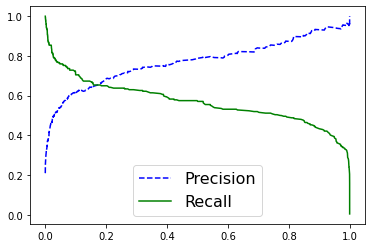

In [154]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### 3) Clasificación multiclase

PAra extender este modelo de clasificación binario a multiclase, entrenaría el modelo para cada uno de los mails de los cursos con su propia etiqueta.
Luego para la clasificación de un mail nuevo, lo evalúo en cada uno de los modelos y me quedo con el clasificador que entregue el mejor score.
Este es el enfoque _one-versus-the-rest_.

### Curva ROC

In [155]:
fpr, tpr, thresholds = roc_curve(y_true, y_predict_values)

La curva ROC es un gráfico que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Esta curva representa dos parámetros:
* Tasa de verdaderos positivos
* Tasa de falsos positivos

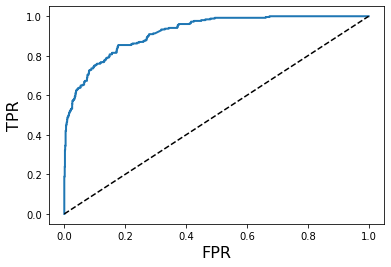

In [156]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16) 
    
plot_roc_curve(fpr, tpr)
plt.show()

In [157]:
roc_auc_score(y_true, y_predict_values)

0.9197129594115923

En este caso el área bajo la curva nos entrega un valor muy cercano a 1, lo que indica que tenemos un buen clasificador.
Aunque podríamos obtener un mejor valor.